<a href="https://colab.research.google.com/github/Himatora/project_analitics/blob/master/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D1%8B_%D0%BF%D0%BE_%D1%81%D1%82%D1%83%D0%B4%D0%B5%D0%BD%D1%82%D0%B0%D0%BC_(%D0%B1%D0%B5%D0%B7_%D0%BF%D0%BE%D1%81%D0%B5%D1%89%D0%B0%D0%B5%D0%BC%D0%BE%D1%81%D1%82%D0%B8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

In [7]:
students = pd.read_csv('/content/cleaned_students.csv', sep=';',
                      encoding='windows-1251')

In [8]:
students

,Faculty,Faculty_ID,Speciality,Speciality_ID,Group,Student_ID,Birthday,Is_Academic,Discipline_ID,Discipline,Result_ID,Result
0,Байкальский институт БРИКС,50,Возобновляемая энергетика / Renewable energy,859,ВЭАм-24,2460979,13.09.2000,0,19992,Аварийные режимы в электроэнергетических систе...,3.0,3
1,Байкальский институт БРИКС,50,Возобновляемая энергетика / Renewable energy,859,ВЭАм-24,2460979,13.09.2000,0,17359,Академическое письмо / Academic Writing,6.0,Зачтено
2,Байкальский институт БРИКС,50,Возобновляемая энергетика / Renewable energy,859,ВЭАм-24,2460979,13.09.2000,0,20051,Аналоговые и цифровые системы измерений / Anal...,6.0,Зачтено
3,Байкальский институт БРИКС,50,Возобновляемая энергетика / Renewable energy,859,ВЭАм-24,2460979,13.09.2000,0,20129,Возобновляемые энергоресурсы / Renewable energ...,4.0,4
4,Байкальский институт БРИКС,50,Возобновляемая энергетика / Renewable energy,859,ВЭАм-24,2460979,13.09.2000,0,20229,Защита и управление распределенной генерацией ...,3.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
465633,Центр образовательных программ магистратуры и ...,55,Энергетические системы и комплексы,951,аЭНК-24,2473476,24.07.2000,0,13594,История и философия науки,4.0,4
465634,Центр образовательных программ магистратуры и ...,55,Энергетические системы и комплексы,951,аЭНК-24,2473476,24.07.2000,0,22583,Подготовительный этап выполнения научного иссл...,5.0,5
465635,Центр образовательных программ магистратуры и ...,55,Энергетические системы и комплексы,951,аЭНК-24,2473479,23.07.2000,0,3254,Иностранный язык,5.0,5
465636,Центр образовательных программ магистратуры и ...,55,Энергетические системы и комплексы,951,аЭНК-24,2473479,23.07.2000,0,13594,История и философия науки,4.0,4


In [12]:
# Удаляем строки, где Result либо пусто (NaN), либо содержит "Студент не найден"
initial_rows = len(students)
print(f"Исходное количество строк: {initial_rows}")

# Удаляем строки с пустыми значениями в Result
students = students.dropna(subset=['Result'])

# Удаляем строки, где Result содержит "Студент не найден" (регистронезависимо)
mask = ~students['Result'].astype(str).str.contains('студент не найден', case=False, na=False)
students = students[mask].reset_index(drop=True)

final_rows = len(students)
print(f"Количество строк после очистки: {final_rows}")
print(f"Удалено строк: {initial_rows - final_rows}")

# Покажем примеры оставшихся значений в Result
print("\nПримеры значений в Result после очистки:")
print(students['Result'].unique()[:15])

Исходное количество строк: 465638
Количество строк после очистки: 465621
Удалено строк: 17

Примеры значений в Result после очистки:
['3' 'Зачтено' '4' '5' 'Н/Я' '2' 'Не зачтено']


In [20]:
# Определение долга (целевая переменная)
def is_debt(result):
    """
    Определяет, является ли результат долгом
    Долг: оценки 2 или "Незачтено"
    """
    if isinstance(result, str):
        return 1 if 'Не зачтено' in result or 'Н/Я' in result or '2' in result else 0


students['is_debt'] = students['Result'].apply(is_debt)

# Проверка распределения
print(f"Распределение классов: {students['is_debt'].value_counts()}")
print(f"Доля долгов: {students['is_debt'].mean():.2%}")

Распределение классов: is_debt
0    403156
1     62465
Name: count, dtype: int64
Доля долгов: 13.42%


In [23]:
itiad_df = students[students['Faculty'] == 'Институт информационных технологий и анализа данных'].copy()

print(f"Количество студентов ИТИАД: {len(itiad_df)}")
print(f"Количество уникальных студентов ИТИАД: {itiad_df['Student_ID'].nunique()}")


Количество студентов ИТИАД: 21671
Количество уникальных студентов ИТИАД: 634


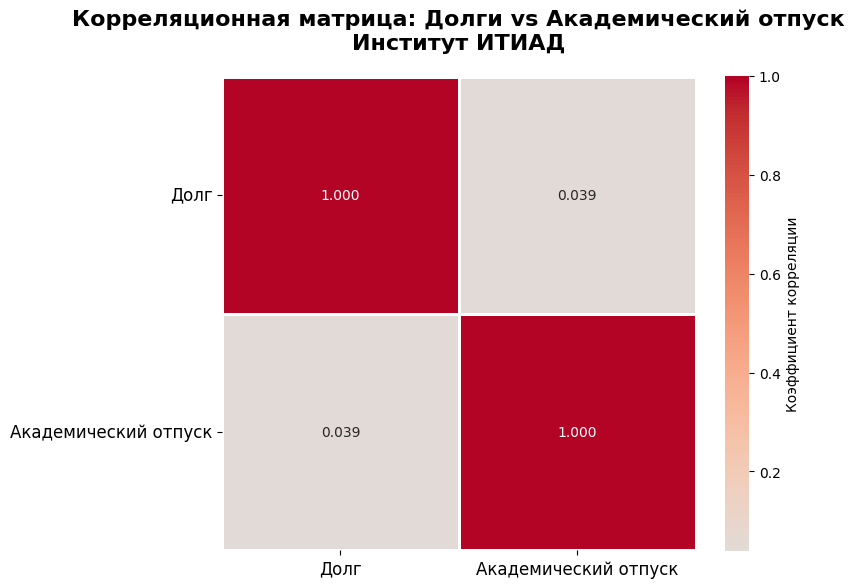

In [31]:
# Создаем DataFrame с нужными признаками
correlation_df = itiad_df[['is_debt', 'Is_Academic']].copy()

# Корреляционная матрица (Пирсон)
corr_matrix = correlation_df.corr(method='pearson')

# Визуализация тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix,
            annot=True,
            fmt='.3f',
            cmap='coolwarm',
            center=0,
            square=True,
            cbar_kws={'label': 'Коэффициент корреляции'},
            linewidths=1,
            linecolor='white')

plt.title('Корреляционная матрица: Долги vs Академический отпуск\nИнститут ИТИАД',
          fontsize=16, fontweight='bold', pad=20)
plt.xticks([0.5, 1.5], ['Долг', 'Академический отпуск'], fontsize=12)
plt.yticks([0.5, 1.5], ['Долг', 'Академический отпуск'], fontsize=12, rotation=0)


plt.tight_layout()
plt.show()

In [33]:
# Просто добавляем столбец с базовым названием группы
itiad_df['Group_Base'] = itiad_df['Group'].str.extract(r'([A-Za-zА-Яа-я]+)')[0]

# Теперь можно фильтровать по группе
group_name = 'ИСТб'  # например
group_df = itiad_df[itiad_df['Group_Base'] == group_name]

print(f"Группа {group_name}:")
print(f"- Всего записей: {len(group_df)}")
print(f"- Уникальных студентов: {group_df['Student_ID'].nunique()}")
print(f"- Варианты названий: {group_df['Group'].unique()}")
print(f"- Года: {sorted(group_df['Group'].str.extract(r'(\d+)')[0].dropna().unique())}")

Группа ИСТб:
- Всего записей: 5709
- Уникальных студентов: 154
- Варианты названий: ['ИСТб-21' 'ИСТб-22' 'ИСТб-23' 'ИСТб-24']
- Года: ['21', '22', '23', '24']


При переводе у студента сохраняются оценки за предметы, где он учился до этого

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Функция для нормализации оценок
def normalize_grade(grade):
    if pd.isna(grade):
        return np.nan

    if isinstance(grade, str):
        grade_lower = grade

        if 'Зачтено' in grade_lower and 'Не зачтено' not in grade_lower:
            return 5.0
        elif 'Не зачтено' in grade_lower or 'Н/Я' in grade_lower:
            return 2.0
        else:
            try:
                clean_grade = ''.join(c for c in grade if c.isdigit() or c == '.' or c == ',')
                clean_grade = clean_grade.replace(',', '.')
                return float(clean_grade)
            except:
                return np.nan
    else:
        try:
            return float(grade)
        except:
            return np.nan

**Разработка системы для предсказания будущей успеваемости студентов на основе их текущих академических показателей с использованием глубокого обучения (PyTorch).**

Задачи
Анализ исторических данных успеваемости студентов группы ИСТб

Построение модели для прогнозирования средних оценок на будущих курсах

Выявление студентов с риском ухудшения успеваемости

Формирование персонализированных рекомендаций
# Признаки для модели:
feature_cols = [

    'avg_grade',           # Средняя оценка
    'std_grade',           # Стандартное отклонение оценок
    'min_grade',           # Минимальная оценка
    'max_grade',           # Максимальная оценка
    'num_subjects',        # Количество предметов
    'excellent_rate',      # Доля отличных оценок (≥4.5)
    'good_rate',           # Доля хороших оценок (4.0-4.5)
    'satisfactory_rate',   # Доля удовлетворительных оценок (3.0-4.0)
    'poor_rate',           # Доля плохих оценок (<3.0)
    'unique_grades'        # Количество уникальных оценок
]

Параметры модели
Входной размер: 10 признаков

Скрытые слои: 32 → 16 → 8 нейронов

Активация: ReLU

Регуляризация: Dropout (30%)

Выход: 1 нейрон (регрессия)
Интерпретация метрик:

R² = 0.357: Модель объясняет 35.7% дисперсии в данных

MAE = 0.236: Средняя ошибка предсказания ±0.24 балла

RMSE = 0.286: Типичное отклонение предсказания от фактических значений

Исходное количество записей: 5709
После удаления некорректных оценок: 5709

Создаем расширенные признаки для студентов...
Создано 154 записей с признаками

Подготовка данных для модели предсказания...
Студентов 1 курса: 60
Студентов 2 курса: 44
Студентов 3 курса: 47
Студентов 4 курса: 3
Размерность X: (94, 10)
Размерность y: (94,)
Тренировочные примеры: 75
Тестовые примеры: 19

Модель создана с 10 входными признаками
Количество параметров: 1025

Начинаем обучение модели...
Epoch [20/200], Train Loss: 15.5957, Val Loss: 17.0870
Epoch [40/200], Train Loss: 1.9939, Val Loss: 1.0364
Epoch [60/200], Train Loss: 2.0878, Val Loss: 0.3593
Epoch [80/200], Train Loss: 1.1973, Val Loss: 0.2980
Epoch [100/200], Train Loss: 0.9817, Val Loss: 0.1904
Epoch [120/200], Train Loss: 1.0778, Val Loss: 0.1539
Epoch [140/200], Train Loss: 0.9748, Val Loss: 0.1529
Epoch [160/200], Train Loss: 0.6304, Val Loss: 0.0487
Epoch [180/200], Train Loss: 0.7941, Val Loss: 0.1347
Epoch [200/200], Train Loss: 0.6306, V

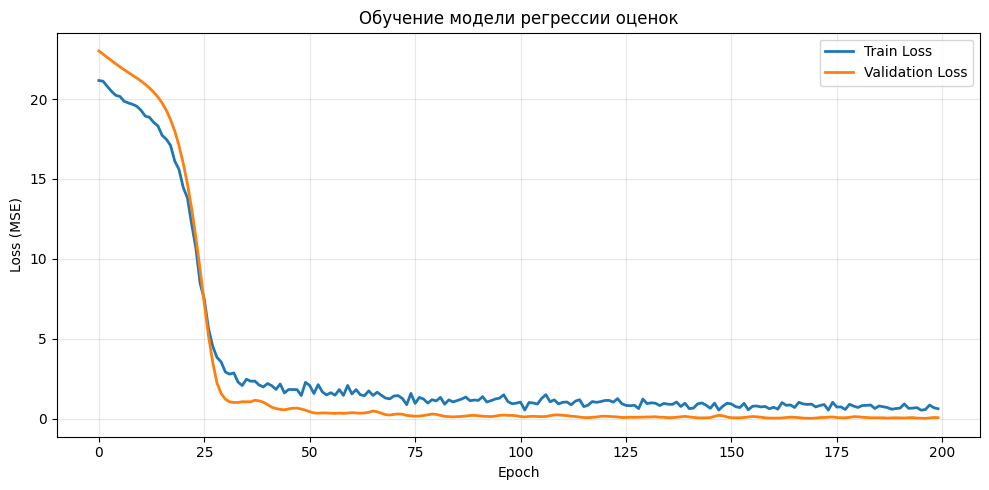


МЕТРИКИ КАЧЕСТВА МОДЕЛИ РЕГРЕССИИ:
MAE (Средняя абсолютная ошибка): 0.232
RMSE (Корень из среднеквадратичной ошибки): 0.261
R² (Коэффициент детерминации): 0.465


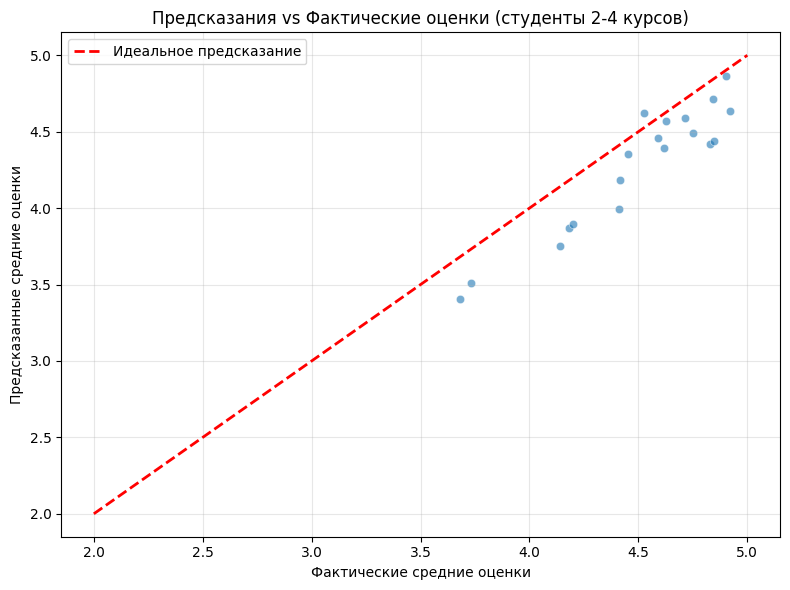


ПРЕДСКАЗАНИЯ ДЛЯ СТУДЕНТОВ 1 КУРСА (ИСТб-24)

Топ-10 студентов с лучшими прогнозами:
 student_id  current_avg_grade  predicted_future_grade  improvement
    2464402           4.500000                5.000000     0.500000
    2464956           4.684211                5.000000     0.315789
    2468093           4.500000                5.000000     0.500000
    2462411           4.473684                4.994156     0.520472
    2470313           4.550000                4.959842     0.409842
    2469217           4.700000                4.933767     0.233767
    2465934           4.944444                4.930207    -0.014238
    2470237           4.947368                4.925927    -0.021441
    2462428           4.722222                4.904023     0.181801
    2465684           4.722222                4.904023     0.181801

Топ-10 студентов с худшими прогнозами:
 student_id  current_avg_grade  predicted_future_grade  improvement
    2471639           2.941176                3.033220    

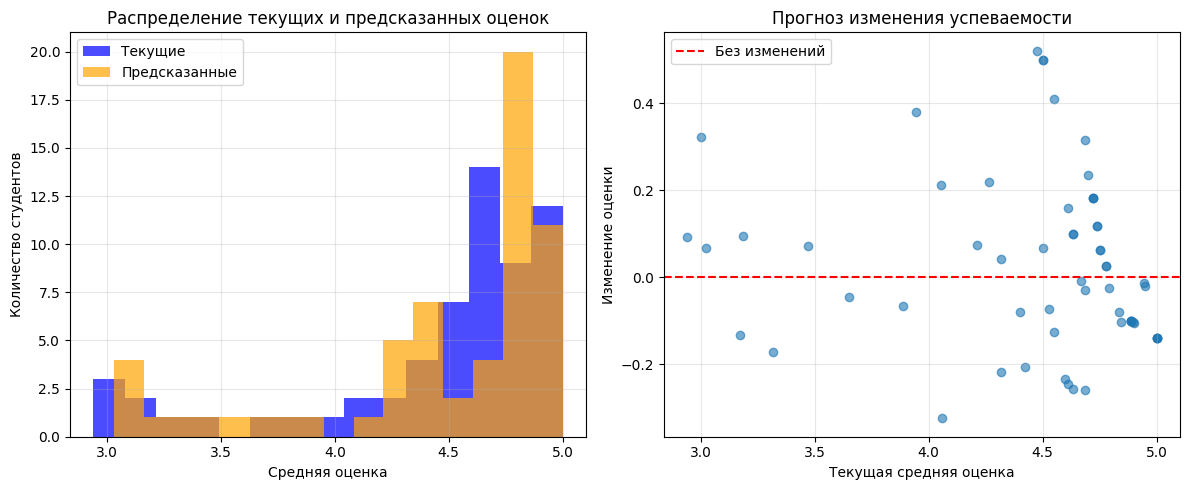


ВАЖНОСТЬ ПРИЗНАКОВ ДЛЯ ПРЕДСКАЗАНИЯ:
          feature  importance
        poor_rate    0.194012
     num_subjects    0.179282
        std_grade    0.176696
        min_grade    0.176318
        good_rate    0.169394
satisfactory_rate    0.169222
    unique_grades    0.167152
        max_grade    0.158732
        avg_grade    0.156227
   excellent_rate    0.149786


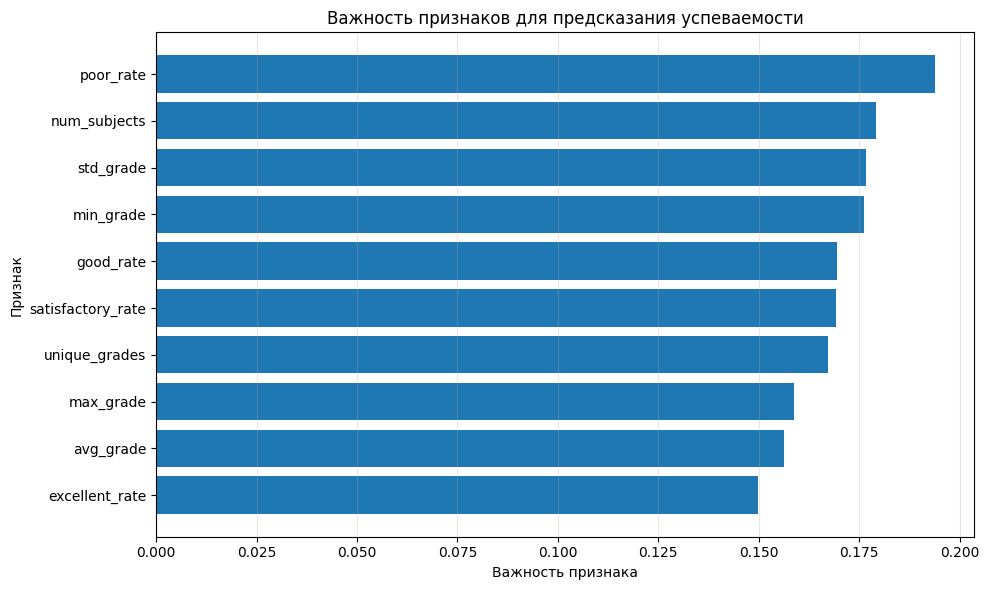


СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
Модель регрессии сохранена в 'grade_regression_model.pth'
Признаки студентов сохранены в 'istb_student_features.csv'
Предсказания для студентов 1 курса сохранены в 'istb_first_course_predictions.csv'
Важность признаков сохранена в 'istb_feature_importance.csv'

РЕКОМЕНДАЦИИ ДЛЯ СТУДЕНТОВ 1 КУРСА

Студенты с риском ухудшения успеваемости (1 чел.):
  Студент 2464069: текущая оценка 4.06, прогноз 3.73 (изменение: -0.32)

Студенты с потенциалом улучшения (7 чел.):
  Студент 2462411: текущая оценка 4.47, прогноз 4.99 (улучшение: 0.52)
  Студент 2464402: текущая оценка 4.50, прогноз 5.00 (улучшение: 0.50)
  Студент 2464956: текущая оценка 4.68, прогноз 5.00 (улучшение: 0.32)
  Студент 2468093: текущая оценка 4.50, прогноз 5.00 (улучшение: 0.50)
  Студент 2470313: текущая оценка 4.55, прогноз 4.96 (улучшение: 0.41)
  Студент 2471210: текущая оценка 3.00, прогноз 3.32 (улучшение: 0.32)
  Студент 2472710: текущая оценка 3.94, прогноз 4.32 (улучшение: 0.38)


In [47]:
# Загружаем данные для группы ИСТб
group_df = itiad_df[itiad_df['Group'].str.contains('ИСТб')].copy()

# Добавляем числовой столбец с оценкой
group_df['grade_numeric'] = group_df['Result'].apply(normalize_grade)

# Удаляем строки с некорректными оценками
print(f"Исходное количество записей: {len(group_df)}")
group_df = group_df.dropna(subset=['grade_numeric'])
print(f"После удаления некорректных оценок: {len(group_df)}")

# Определяем курс студента по группе
def group_to_course(group_name):
    if 'ИСТб-21' in group_name:
        return 4
    elif 'ИСТб-22' in group_name:
        return 3
    elif 'ИСТб-23' in group_name:
        return 2
    elif 'ИСТб-24' in group_name:
        return 1
    else:
        return None

group_df['student_course'] = group_df['Group'].apply(group_to_course)

# Создаем более сложные признаки для каждого студента
print("\nСоздаем расширенные признаки для студентов...")

student_features = []

for student_id in group_df['Student_ID'].unique():
    student_data = group_df[group_df['Student_ID'] == student_id]
    student_course = student_data['student_course'].iloc[0]

    # Базовые признаки
    grades = student_data['grade_numeric'].values

    avg_grade = np.mean(grades)
    std_grade = np.std(grades) if len(grades) > 1 else 0
    min_grade = np.min(grades)
    max_grade = np.max(grades)
    num_subjects = len(grades)

    # Процент оценок в разных диапазонах
    excellent = np.sum(grades >= 4.5) / num_subjects
    good = np.sum((grades >= 4.0) & (grades < 4.5)) / num_subjects
    satisfactory = np.sum((grades >= 3.0) & (grades < 4.0)) / num_subjects
    poor = np.sum(grades < 3.0) / num_subjects

    # Количество различных оценок
    unique_grades = len(np.unique(grades))

    student_features.append({
        'student_id': student_id,
        'student_course': student_course,
        'avg_grade': avg_grade,
        'std_grade': std_grade,
        'min_grade': min_grade,
        'max_grade': max_grade,
        'num_subjects': num_subjects,
        'excellent_rate': excellent,
        'good_rate': good,
        'satisfactory_rate': satisfactory,
        'poor_rate': poor,
        'unique_grades': unique_grades,
        'group': student_data['Group'].iloc[0]
    })

# Создаем DataFrame с признаками
features_df = pd.DataFrame(student_features)

print(f"Создано {len(features_df)} записей с признаками")

# Подготовка данных для модели: предсказываем успеваемость на следующем курсе
print("\nПодготовка данных для модели предсказания...")

# Для студентов 2, 3, 4 курсов используем их текущие признаки для предсказания
# успеваемости на текущем курсе (как бы "предсказываем" их текущую успеваемость по предыдущим данным)
# Но у нас нет разделения на семестры, поэтому будем использовать кросс-валидацию

# Разделяем студентов по курсам
first_course = features_df[features_df['student_course'] == 1]
second_course = features_df[features_df['student_course'] == 2]
third_course = features_df[features_df['student_course'] == 3]
fourth_course = features_df[features_df['student_course'] == 4]

print(f"Студентов 1 курса: {len(first_course)}")
print(f"Студентов 2 курса: {len(second_course)}")
print(f"Студентов 3 курса: {len(third_course)}")
print(f"Студентов 4 курса: {len(fourth_course)}")

# Для обучения будем использовать студентов 2, 3, 4 курсов
# Цель - предсказать среднюю оценку на текущем курсе по признакам

# Выбираем признаки для модели
feature_cols = [
    'avg_grade', 'std_grade', 'min_grade', 'max_grade',
    'num_subjects', 'excellent_rate', 'good_rate',
    'satisfactory_rate', 'poor_rate', 'unique_grades'
]

# Подготовка данных
X = []
y = []

# Создаем примеры для студентов 2, 3, 4 курсов
for _, student in features_df.iterrows():
    if student['student_course'] > 1:  # Только студенты 2,3,4 курсов
        features = [student[col] for col in feature_cols]
        X.append(features)
        y.append(student['avg_grade'])

X = np.array(X)
y = np.array(y)

print(f"Размерность X: {X.shape}")
print(f"Размерность y: {y.shape}")

# Нормализация признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Тренировочные примеры: {X_train.shape[0]}")
print(f"Тестовые примеры: {X_test.shape[0]}")

# Создаем Dataset
class StudentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StudentDataset(X_train, y_train)
test_dataset = StudentDataset(X_test, y_test)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Определяем модель для регрессии
class GradeRegressor(nn.Module):
    def __init__(self, input_size):
        super(GradeRegressor, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(16, 8),
            nn.ReLU(),

            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.model(x)

# Инициализация модели
input_size = X_train.shape[1]
model = GradeRegressor(input_size)

print(f"\nМодель создана с {input_size} входными признаками")
print(f"Количество параметров: {sum(p.numel() for p in model.parameters())}")

# Функция потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

num_epochs = 200
train_losses = []
val_losses = []

print("\nНачинаем обучение модели...")

for epoch in range(num_epochs):
    # Тренировка
    model.train()
    train_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Визуализация процесса обучения
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Обучение модели регрессии оценок')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Оценка модели
def evaluate_model(model, dataloader, device='cpu'):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            predictions = model(batch_X)

            all_predictions.extend(predictions.cpu().numpy().flatten())
            all_targets.extend(batch_y.cpu().numpy().flatten())

    # Вычисляем метрики
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    mae = mean_absolute_error(all_targets, all_predictions)
    mse = mean_squared_error(all_targets, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_predictions)

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'predictions': all_predictions,
        'targets': all_targets
    }

# Оцениваем модель
metrics = evaluate_model(model, test_loader, device)

print("\n" + "="*60)
print("МЕТРИКИ КАЧЕСТВА МОДЕЛИ РЕГРЕССИИ:")
print("="*60)
print(f"MAE (Средняя абсолютная ошибка): {metrics['MAE']:.3f}")
print(f"RMSE (Корень из среднеквадратичной ошибки): {metrics['RMSE']:.3f}")
print(f"R² (Коэффициент детерминации): {metrics['R2']:.3f}")

# Визуализация предсказаний vs фактов
plt.figure(figsize=(8, 6))
plt.scatter(metrics['targets'], metrics['predictions'], alpha=0.6, edgecolors='w', linewidth=0.5)
plt.plot([2, 5], [2, 5], 'r--', label='Идеальное предсказание', linewidth=2)
plt.xlabel('Фактические средние оценки')
plt.ylabel('Предсказанные средние оценки')
plt.title('Предсказания vs Фактические оценки (студенты 2-4 курсов)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Функция для предсказания оценок студентов 1 курса
def predict_first_course_students(model, scaler, first_course_df, feature_cols, device='cpu'):
    model.eval()

    results = []

    for _, student in first_course_df.iterrows():
        features = np.array([student[col] for col in feature_cols]).reshape(1, -1)
        features_scaled = scaler.transform(features)

        with torch.no_grad():
            features_tensor = torch.FloatTensor(features_scaled).to(device)
            predicted_grade_raw = model(features_tensor).item()

            # Ограничиваем диапазон [2.0, 5.0]
            predicted_grade = max(2.0, min(5.0, predicted_grade_raw))

        results.append({
            'student_id': student['student_id'],
            'current_avg_grade': student['avg_grade'],
            'predicted_future_grade': predicted_grade,
            'predicted_raw': predicted_grade_raw,  # Сохраняем исходное значение
            'group': student['group'],
            'improvement': predicted_grade - student['avg_grade']
        })

    return pd.DataFrame(results)

# Предсказываем для студентов 1 курса
if len(first_course) > 0:
    predictions_df = predict_first_course_students(model, scaler, first_course, feature_cols, device)

    print("\n" + "="*60)
    print("ПРЕДСКАЗАНИЯ ДЛЯ СТУДЕНТОВ 1 КУРСА (ИСТб-24)")
    print("="*60)

    # Показываем топ-10 студентов с лучшими и худшими прогнозами
    print("\nТоп-10 студентов с лучшими прогнозами:")
    top_students = predictions_df.nlargest(10, 'predicted_future_grade')
    print(top_students[['student_id', 'current_avg_grade', 'predicted_future_grade', 'improvement']].to_string(index=False))

    print("\nТоп-10 студентов с худшими прогнозами:")
    bottom_students = predictions_df.nsmallest(10, 'predicted_future_grade')
    print(bottom_students[['student_id', 'current_avg_grade', 'predicted_future_grade', 'improvement']].to_string(index=False))

    # Статистика по предсказаниям
    print(f"\nСтатистика предсказаний:")
    print(f"Средняя текущая оценка: {predictions_df['current_avg_grade'].mean():.2f}")
    print(f"Средняя предсказанная оценка: {predictions_df['predicted_future_grade'].mean():.2f}")
    print(f"Среднее изменение: {predictions_df['improvement'].mean():.2f}")

    # Визуализация распределения предсказаний
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Гистограмма текущих и предсказанных оценок
    axes[0].hist(predictions_df['current_avg_grade'], bins=15, alpha=0.7, label='Текущие', color='blue')
    axes[0].hist(predictions_df['predicted_future_grade'], bins=15, alpha=0.7, label='Предсказанные', color='orange')
    axes[0].set_xlabel('Средняя оценка')
    axes[0].set_ylabel('Количество студентов')
    axes[0].set_title('Распределение текущих и предсказанных оценок')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # График улучшений
    axes[1].scatter(predictions_df['current_avg_grade'], predictions_df['improvement'], alpha=0.6)
    axes[1].axhline(y=0, color='red', linestyle='--', label='Без изменений')
    axes[1].set_xlabel('Текущая средняя оценка')
    axes[1].set_ylabel('Изменение оценки')
    axes[1].set_title('Прогноз изменения успеваемости')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Анализ важности признаков
def analyze_feature_importance(model, feature_cols):
    """
    Анализирует важность признаков по весам первого слоя
    """
    weights = model.model[0].weight.data.cpu().numpy()
    importance = np.mean(np.abs(weights), axis=0)

    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': importance
    }).sort_values('importance', ascending=False)

    return feature_importance

# Анализ важности признаков
importance_df = analyze_feature_importance(model, feature_cols)

print("\n" + "="*60)
print("ВАЖНОСТЬ ПРИЗНАКОВ ДЛЯ ПРЕДСКАЗАНИЯ:")
print("="*60)
print(importance_df.to_string(index=False))

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков для предсказания успеваемости')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Сохранение модели и результатов
print("\n" + "="*60)
print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*60)

# Сохраняем модель
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler': scaler,
    'feature_cols': feature_cols,
    'losses': {'train': train_losses, 'val': val_losses},
    'metrics': metrics
}, 'grade_regression_model.pth')

print("Модель регрессии сохранена в 'grade_regression_model.pth'")

# Сохраняем признаки студентов
features_df.to_csv('istb_student_features.csv', index=False, encoding='utf-8')
print("Признаки студентов сохранены в 'istb_student_features.csv'")

# Сохраняем предсказания для студентов 1 курса
if 'predictions_df' in locals():
    predictions_df.to_csv('istb_first_course_predictions.csv', index=False, encoding='utf-8')
    print("Предсказания для студентов 1 курса сохранены в 'istb_first_course_predictions.csv'")

# Сохраняем важность признаков
importance_df.to_csv('istb_feature_importance.csv', index=False, encoding='utf-8')
print("Важность признаков сохранена в 'istb_feature_importance.csv'")

# Генерация рекомендаций для студентов
print("\n" + "="*60)
print("РЕКОМЕНДАЦИИ ДЛЯ СТУДЕНТОВ 1 КУРСА")
print("="*60)

if 'predictions_df' in locals():
    # Студенты с риском ухудшения успеваемости
    at_risk_students = predictions_df[predictions_df['improvement'] < -0.3]

    if len(at_risk_students) > 0:
        print(f"\nСтуденты с риском ухудшения успеваемости ({len(at_risk_students)} чел.):")
        for _, student in at_risk_students.iterrows():
            print(f"  Студент {student['student_id']}: текущая оценка {student['current_avg_grade']:.2f}, "
                  f"прогноз {student['predicted_future_grade']:.2f} (изменение: {student['improvement']:.2f})")

    # Студенты с потенциалом улучшения
    improving_students = predictions_df[predictions_df['improvement'] > 0.3]

    if len(improving_students) > 0:
        print(f"\nСтуденты с потенциалом улучшения ({len(improving_students)} чел.):")
        for _, student in improving_students.iterrows():
            print(f"  Студент {student['student_id']}: текущая оценка {student['current_avg_grade']:.2f}, "
                  f"прогноз {student['predicted_future_grade']:.2f} (улучшение: {student['improvement']:.2f})")
